# HH and WB model specifications
This lays out the parameterizations for the Hodgkin-Huxley (HH) and Wang-Buzsaki (WB) point cells for the event-based encodings manuscript.

The Wang-Buzsaki is first described in https://doi.org/10.1523/jneurosci.16-20-06402.1996, and built here after the implementation from the ModelDB entry 26997.

In [1]:
import sys
import numpy as np
import random
import pandas as pd
from neuron import h
h.load_file("stdrun.hoc")

import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import matplotlib as mpl
sys.path.insert(1, "../utils/")
import HH, WB, Stimuli

from scipy.spatial import distance

from neuron import h
h.load_file("stdrun.hoc")
from neuron.units import mV, ms

## generate stimuli

In [2]:
sim_duration = 100000

stim_types = ['base','lw','lt','lwlt','burst']

e_times = Stimuli.poisson_process_duration(5, sim_duration)
i_times = Stimuli.poisson_process_duration(15, sim_duration)

In [3]:
figures_dir = '../figures/'

## set up point cell models
The stim_scaffold, from `./utils/Stimuli.py`,  holds all of the synaptic parameterizations necessary to get the different types of HH point cell behaviors.

The HH and WB cells must be run separately as they use different temperatures and NEURON cannot set temperatures differently for different cells.

In [4]:
stim_params = Stimuli.ExperimentalStimParams()
stim_scaffold = stim_params.stim_scaffold

for stim_type in stim_scaffold:
    stim_scaffold[stim_type]['ex'].stim_times = e_times
    stim_scaffold[stim_type]['in'].stim_times = i_times

In [5]:
sims = {stim_type:HH.HH() for stim_type in stim_types}

for stim_type in stim_types:
    sims[stim_type].add_custom_stimulus(stim_scaffold[stim_type]['ex'])
    sims[stim_type].add_custom_stimulus(stim_scaffold[stim_type]['in'])
h.celsius = 6.3
sims[stim_type].run_simulation(sim_duration)

# commit state variables before running WB model
state_vars = {}
spikes = {}
for stim_type in sims:
    state_vars[stim_type] = np.array(
        [sims[stim_type]._v, sims[stim_type]._m, sims[stim_type]._h, sims[stim_type]._n]
    )
    spikes[stim_type] = list(sims[stim_type].spike_times)

/home/ec753/venvs/jupyter_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


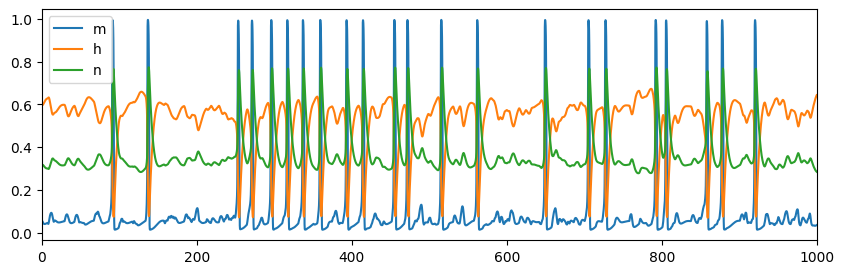

In [6]:
plt.figure(figsize = (10, 3))
plt.plot(sims['base']._t, sims['base']._m)
plt.plot(sims['base']._t, sims['base']._h)
plt.plot(sims['base']._t, sims['base']._n)
plt.xlim(0,1000)

plt.legend(['m','h','n'])
plt.show()

In [7]:
# Wang Buzsaki model
stim_scaffold['wb']['ex'].stim_times = e_times
stim_scaffold['wb']['in'].stim_times = i_times
wb = WB.WB()
wb.add_custom_stimulus(stim_scaffold['wb']['ex'])
wb.add_custom_stimulus(stim_scaffold['wb']['in'])
h.celsius = 37
wb.run_simulation(sim_duration)

state_vars['wb'] = np.array([wb._v, wb._m_kdr, wb._h_naf])
spikes['wb'] = list(wb.spike_times)
t = wb._t

In [8]:
colors = {
    'base':'maroon',
    'lw':'orangered',
    'lt':'darkgreen',
    'lwlt':'teal',
    'burst':'indigo',
    'wb':'black'
}

## General Statistics

In [9]:
for stim_type in spikes:
    isis = [spikes[stim_type][i+1] - spikes[stim_type][i] for i in range(len(spikes[stim_type])-1)]

    print(stim_type)
    print(f'\taverage spike frequency: {len(spikes[stim_type]) / (sim_duration / 1000)} Hz')
    print(f'\tcoefficient of variation (CV) of ISIs: {np.std(isis) / np.mean(isis)}')
    print()

base
	average spike frequency: 21.49 Hz
	coefficient of variation (CV) of ISIs: 0.6835068362128309

lw
	average spike frequency: 13.87 Hz
	coefficient of variation (CV) of ISIs: 0.8066953097899253

lt
	average spike frequency: 17.41 Hz
	coefficient of variation (CV) of ISIs: 0.8503765463243705

lwlt
	average spike frequency: 22.66 Hz
	coefficient of variation (CV) of ISIs: 0.7232324742476655

burst
	average spike frequency: 29.49 Hz
	coefficient of variation (CV) of ISIs: 0.9169326921901553

wb
	average spike frequency: 24.73 Hz
	coefficient of variation (CV) of ISIs: 0.6988506403441768



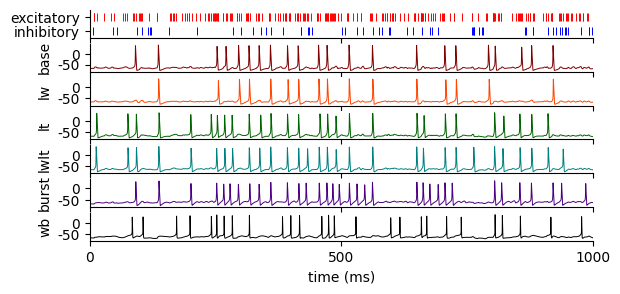

In [18]:
fig, axes = plt.subplots(7,1, figsize=(6.5,3), sharex=True)

axes[0].vlines(e_times, .2, .8, color='red', linewidth=.7)
axes[0].vlines(i_times, -.8, -.2, color='blue', linewidth=.7)
axes[0].set_ylim(-1,1)
axes[0].set_yticks([.5,-.5])
axes[0].set_yticklabels(['excitatory','inhibitory'])
axes[0].spines['right'].set_visible(False)
axes[0].spines['top'].set_visible(False)

for ax, stim_type in enumerate(state_vars):
    axes[ax+1].plot(t, state_vars[stim_type][0,:], c=colors[stim_type], linewidth=.7)
    axes[ax+1].set_ylabel(stim_type)
    
    axes[ax+1].spines['right'].set_visible(False)
    axes[ax+1].spines['top'].set_visible(False)
    
    axes[ax+1].set_yticks([-50,0])
    axes[ax+1].set_yticklabels([-50, 0])

xlim = 1000
axes[-1].set_xlim(0, xlim)
axes[-1].set_xlabel('time (ms)')

xticks = np.arange(0,xlim+1, 500)
axes[-1].set_xticks(xticks)
axes[-1].set_xticklabels(xticks)

#plt.tight_layout()

savefig = False
if savefig:
    plt.savefig(f'{figures_dir}point_cell_traces_with_WB.svg', format='svg')
    plt.savefig(f'{figures_dir}point_cell_traces_with_WB.png', format='png', dpi=300)

plt.show()

## median histories & spiking histories
The Median history of a neuron model is its state variable frame closest to the median value of each standardized state variables over the duration of a simulation. Functionally, it represents the expected subthreshold position along the model's state space provided no prior information about the knowledge of stimuli or state variables. 

Spiking histories are the state variable frames of a model upon a spike event. We denote the start of a spike as the first frame after which the model's Vm crosses 0 mv from below. They represent the model's states at the initiation of a spike event.

In [11]:
def standarize_column(column):
    # set column to fit in (0,1)
    column = column-np.min(column)
    column = column/np.max(column)
    return column

def get_median_history(state_vars):
    # state_vars: np array

    # calculate the median of each state variable
    median_values = np.median(state_vars, axis = 1)
    
    dists = []
    for i in range(state_vars.shape[1]):
        dists.append(distance.euclidean(state_vars[:,i], median_values))

    return state_vars[:, np.argmin(dists)]

def isolate_spiking_histories(state_vars, spikes):
    spiking_histories = []
    for spike in spikes:
        row = round(40 * spike)
        spiking_histories.append(state_vars[:,row])                              
    return np.array(spiking_histories)

In [12]:
median_histories = {}
spiking_histories = {}

for stim_type in state_vars:
    print(stim_type)
    median_histories[stim_type] = get_median_history(state_vars[stim_type])
    spiking_histories[stim_type] = isolate_spiking_histories(state_vars[stim_type], spikes[stim_type])

base
lw
lt
lwlt
burst
wb


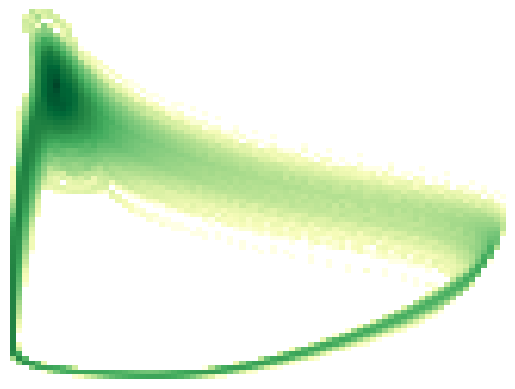

In [13]:
stim_type = 'base'
plt.hist2d(state_vars[stim_type][0,:], state_vars[stim_type][2,:], cmap='YlGn', bins=80, cmin=1, norm=mpl.colors.LogNorm())

plt.axis('off')
#plt.savefig('HHmanifold.png', dpi = 600, transparent=True)

plt.show()

In [14]:
fig, axes = plt.subplots(1,6, figsize=(6.5, 2), sharex=True, sharey=True)

ax_ind = 0
for stim_type in stim_types + ['wb']:
    print(f'drawing {stim_type}')
    
    axes[ax_ind].hist2d(state_vars[stim_type][0,:], state_vars[stim_type][2,:], 
                        bins=80, cmin=1, norm=mpl.colors.LogNorm())
    # median history
    med_history = median_histories[stim_type]
    axes[ax_ind].scatter(med_history[0], med_history[2], c='red', s=1)
    # spiking history
    spike_histories = spiking_histories[stim_type]
    
    for i in range(spike_histories.shape[0]):
        axes[ax_ind].scatter(spike_histories[:,0], spike_histories[:,2], c='orange', alpha=1, s=.2)
    
    
    axes[ax_ind].set_title(stim_type)
    axes[ax_ind].set_xlabel('Vm')
    
    axes[ax_ind].spines['top'].set_visible(False)
    axes[ax_ind].spines['right'].set_visible(False)
    ax_ind += 1
    
axes[-1].set_xlim(
    np.min(np.array([state_vars[stim_type][0,:] for stim_type in stim_types+['wb']])),
    np.max(np.array([state_vars[stim_type][0,:] for stim_type in stim_types+['wb']]))
)
axes[-1].set_ylim(
    np.min(np.array([state_vars[stim_type][2,:] for stim_type in stim_types+['wb']])),
    np.max(np.array([state_vars[stim_type][2,:] for stim_type in stim_types+['wb']]))
)

axes[0].set_ylabel('h')

plt.tight_layout()

savefig = False
if savefig:
    plt.savefig(f'{figures_dir}point_cell_manifolds_with_WB.png', format='png', dpi=300)

plt.show()

drawing base
drawing lw
drawing lt
drawing lwlt
drawing burst
drawing wb


KeyboardInterrupt: 